In [4]:
# The code was removed by Watson Studio for sharing.

# Smart Policing in Detroit, MI, USA
## By: Yong Shen
#### Below, you'll find the code for the Smart Policing data analysis project.

### 1. Data Import. 

I downloaded the dataset from City of Detroit's Open Data website (https://data.detroitmi.gov/datasets/all-crime-incidents-december-6-2016-present/data) and uploaded that to the Project as an asset.

In [5]:
#There's a hidden cell above that automatically is created to allow for the import of the Project from python_lib
#to create a Project object to read assets in the project space.

# Fetch the file
my_file = project.get_file("All_Crime_Incidents_December_6_2016__Present.csv")

# Read the CSV data file from the object storage into a pandas DataFrame
my_file.seek(0)
import pandas as pd
df = pd.read_csv(my_file)
df.head()

,X,Y,crime_id,report_number,address,offense_description,offense_category,state_offense_code,arrest_charge,charge_description,...,scout_car_area,precinct,block_id,neighborhood,council_district,zip_code,longitude,latitude,ibr_date,ObjectId
0,-0.000748,0.000381,3408085,1909080130,16700 block of ASHTON AVE,MOTOR VEHICLE THEFT,STOLEN VEHICLE,2401,24001,MOTOR VEHICLE THEFT,...,811,8,2.616354e+14,North Rosedale Park,1.0,NaN,-83.22005,42.41322,2019-09-11T09:46:59.000Z,2002
1,-0.000748,0.000381,3408603,1909090274,16700 block of PATTON ST,MOTOR VEHICLE THEFT,STOLEN VEHICLE,2401,24001,MOTOR VEHICLE THEFT,...,810,8,2.616354e+14,McNichols Evergreen,1.0,NaN,-83.24438,42.41250,2019-09-13T13:41:19.000Z,2003
2,-0.000745,0.000381,3410043,1909120394,Corner of PEERLESS ST and MORANG DR,MOTOR VEHICLE THEFT,STOLEN VEHICLE,2401,24001,MOTOR VEHICLE THEFT,...,907,9,2.616350e+14,Yorkshire Woods,4.0,NaN,-82.93953,42.42188,2019-09-17T08:57:46.000Z,2004
3,-0.000747,0.000381,3410196,1909130100,9000 block of CLOVERLAWN ST,MOTOR VEHICLE THEFT,STOLEN VEHICLE,2401,24001,MOTOR VEHICLE THEFT,...,209,2,2.616353e+14,Barton-McFarland,7.0,NaN,-83.15097,42.36139,2019-09-17T08:57:46.000Z,2005
4,-0.000747,0.000381,3410240,1909130146,17300 block of FREELAND ST,MOTOR VEHICLE THEFT,STOLEN VEHICLE,2401,24001,MOTOR VEHICLE THEFT,...,1206,12,2.616354e+14,Winship,2.0,NaN,-83.18620,42.41891,2019-09-17T08:57:46.000Z,2006


In [6]:
#Let's first check the datatypes of the various columns to make sure they are good.
print(df.shape)
df.dtypes

(21752, 25)


X                      float64
Y                      float64
crime_id                 int64
report_number            int64
address                 object
offense_description     object
offense_category        object
state_offense_code       int64
arrest_charge            int64
charge_description      object
incident_timestamp      object
incident_time            int64
day_of_week              int64
hour_of_day              int64
year                     int64
scout_car_area           int64
precinct                 int64
block_id               float64
neighborhood            object
council_district       float64
zip_code               float64
longitude              float64
latitude               float64
ibr_date                object
ObjectId                 int64
dtype: object

In [7]:
#Okay. So we have 21752 criminal records to work with. Counting by years to see how many crimes are reported per year
df['year'].value_counts()

2019    21752
Name: year, dtype: int64

So apparently the data only contains criminal records from the year of 2019. This actually makes our analysis easier because the dataset won't be too large.
In fact, to further clean the data I will randomly sample 200 data points from the dataframe (~1% of the dataset) to make visualization even more amenable and to save some space later for Foursquare API calls because I only get 25,000 (I think?).

In [8]:
df = df.sample(n=200, replace=True, axis=0)
print(df.shape)

(200, 25)


To further clean the data, let's get rid of the columns we don't need in this analysis project (like assault description, other kinds of extraneous IDs), and create a new index. 

In [9]:
df = df[['offense_category','neighborhood','longitude','latitude']]
df.head()

,offense_category,neighborhood,longitude,latitude
20786,LARCENY,Nardin Park,-83.13435,42.37578
2101,LARCENY,Fitzgerald/Marygrove,-83.16997,42.41452
21751,DAMAGE TO PROPERTY,Farwell,-83.05802,42.43891
12294,LARCENY,Morningside,-82.94724,42.40599
3305,FRAUD,Conner Creek,-82.99523,42.44909


In [10]:
df = df.reset_index(drop=True)
#I found out later that there are some NaN values after trying to make the map in the dataframe so I'm gonna have to clean it by dropping
#the rows that have a NaN
df.dropna(inplace=True)
print(df.shape)

(195, 4)


### 2. Exploratory Data Analysis with Folium and DBSCAN

Ok. Now that the data is cleaned, let's plot them first on a folium map to see if we can find anything with our naked eyes. 

In [12]:
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
!conda install -c conda-forge folium 
import folium

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    altair-3.2.0               |           py36_0         770 KB  conda-forge
    folium-0.10.0              |             py_0          59 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.3 MB

The following NEW packages will be INSTAL

In [13]:
#First, find the latitude and longtitude of Detroit city.
address = 'Detroit, MI'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Detroit city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Detroit city are 42.3315509, -83.0466403.


In [14]:
#Create a folium map with the crimes overlaid.
map_detroit = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(df['latitude'], df['longitude'], df['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_detroit)  

map_detroit

I found out that using even 10% of the original dataset makes the rendering of a folium map unfeasible. Not great for data visualization. So I decided to go back and cut down to 200 samples from the original dataset. What do we find with our naked eye just by looking at this map? Well, it seems that there are three clusters of criminal activity based on the density. One in the West, one in Southern Detroit, near the border with Windsor, and the other in the East. There are also a couple of outliers in the neighborhood of Lincoln Park. But we'll have to resort to machine learning to make this clearer.

In [15]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = df[['latitude','longitude']]
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

In [24]:
# Compute DBSCAN
db = DBSCAN(eps=0.45, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 
set(labels)

{-1, 0, 1, 2}

In [25]:
#Create another map with folium called map_detroit_DBSCAN
map_detroit_DBSCAN = folium.Map(location=[latitude, longitude], zoom_start=9)

#We have 4 clusters, based on the DBSCAN parameters we put in. Let's assign colors to each of these labels
def ClusColors(rec):
    if rec['Clus_Db'] == -1:
        return 'grey'
    elif rec['Clus_Db'] == 0:
        return 'red'
    elif rec['Clus_Db'] == 1:
        return 'green'
    else:
        return 'blue'

df['color'] = df.apply(ClusColors, axis=1)
df.head()

,offense_category,neighborhood,longitude,latitude,Clus_Db,color
0,LARCENY,Nardin Park,-83.13435,42.37578,0,red
1,LARCENY,Fitzgerald/Marygrove,-83.16997,42.41452,0,red
2,DAMAGE TO PROPERTY,Farwell,-83.05802,42.43891,1,green
3,LARCENY,Morningside,-82.94724,42.40599,1,green
4,FRAUD,Conner Creek,-82.99523,42.44909,1,green


In [26]:
for lat, lng, neighborhood, cluster, colors in zip(df['latitude'], df['longitude'], df['neighborhood'], df['Clus_Db'], df['color']):
    label = 'Neighborhood: {}, Cluster: {}'.format(neighborhood, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_detroit)  

map_detroit

This is pretty interesting! It seems that there are three density-based clusters, which corresponds roughly to what I observed a while ago.

### 3. K-means Clustering of Crime Locations based on Foursquare API

In this section we'll call Foursquare API to cluster crime locations in a different way: via similarities between the venues located next to them. This will also help with public safety efforts and provide insights into criminal activity patterns in Detroit.

In [1]:
CLIENT_ID = '4XGEYWNDEWJE055VQ0IO32LY4DPSUTVVKIYXKL23KEKMKNWZ' # your Foursquare ID
CLIENT_SECRET = 'QKPCUJXNFQZV14MQX01HQI5EXWQLLTOWOOBQVUISODFCAWTX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4XGEYWNDEWJE055VQ0IO32LY4DPSUTVVKIYXKL23KEKMKNWZ
CLIENT_SECRET:QKPCUJXNFQZV14MQX01HQI5EXWQLLTOWOOBQVUISODFCAWTX


In [27]:
import requests

limit = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [29]:
detroit_venues = getNearbyVenues(names=df['neighborhood'], latitudes=df['latitude'], longitudes=df['longitude'])
print(detroit_venues.shape)

(1792, 7)


In [30]:
#Do some one-hot encoding on the venues info
detroit_onehot = pd.get_dummies(detroit_venues[['Venue Category']], prefix="", prefix_sep="")
detroit_onehot['Neighborhood'] = detroit_venues['Neighborhood'] 
fixed_columns = [detroit_onehot.columns[-1]] + list(detroit_onehot.columns[:-1])
detroit_onehot = detroit_onehot[fixed_columns]

detroit_onehot.shape

(1792, 223)

In [39]:
#We group them and assign the mean of the frequency of appearance of each neighborhood
detroit_grouped = detroit_onehot.groupby('Neighborhood').mean().reset_index()
detroit_grouped.head()

,Neighborhood,Yoga Studio,ATM,Accessories Store,Alternative Healer,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,Airport Sub,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Barton-McFarland,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Belmont,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Berg-Lahser,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bethune Community,0.0,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
#Here, I'm writing a function to return the most_common_values by descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
#Here, I'll display the top 10 venues in each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe for the data
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = detroit_grouped['Neighborhood']

for ind in np.arange(detroit_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(detroit_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Airport Sub,Intersection,Women's Store,Dry Cleaner,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
1,Barton-McFarland,Cosmetics Shop,Pharmacy,Middle Eastern Restaurant,Fast Food Restaurant,Market,Lounge,Lebanese Restaurant,Playground,Dessert Shop,Department Store
2,Belmont,Fried Chicken Joint,American Restaurant,Nightclub,Liquor Store,Women's Store,Electronics Store,Food & Drink Shop,Food,Flower Shop,Flea Market
3,Berg-Lahser,Intersection,Furniture / Home Store,Women's Store,Dry Cleaner,Food & Drink Shop,Food,Flower Shop,Flea Market,Fish Market,Fish & Chips Shop
4,Bethune Community,Hockey Arena,Pool,Recreation Center,Nightlife Spot,Restaurant,Basketball Court,BBQ Joint,American Restaurant,Convenience Store,Music Venue


In [86]:
#Now we import Kmeans clustering algorithm from scklearn and do kmean clustering
from sklearn.cluster import KMeans

kclusters = 8
detroit_grouped_clustering = detroit_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(detroit_grouped_clustering)

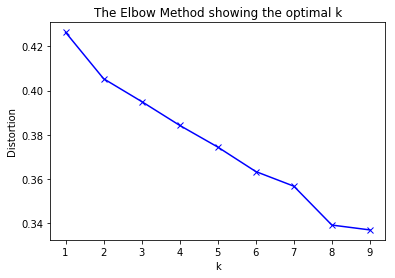

In [82]:
#I want to use the Elbow Method to find the optimal K for K-means clustering
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(detroit_grouped_clustering)
    kmeanModel.fit(detroit_grouped_clustering)
    distortions.append(sum(np.min(cdist(detroit_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / detroit_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

After using the Elbow method, I found that k=8 is probably the best bet for clustering since it seems like the bending point of Distortion values.

In [87]:
#I create a new dataframe with the new data from clustering included
#add clustering labels
neighborhoods_venues_sorted.insert(0, 'K-means Cluster Labels', kmeans.labels_)
#Here I'm gonna change the column name on the original df dataframe foe neighborhood to "Neighborhood"
df.rename(columns={"neighborhood": "Neighborhood"}, inplace=True)
detroit_merged = df
detroit_merged = detroit_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood', how = 'right')
detroit_merged.head()

,offense_category,Neighborhood,longitude,latitude,Clus_Db,color,K-means Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,LARCENY,Nardin Park,-83.13435,42.37578,0,red,2,Home Service,Pizza Place,Business Service,Shopping Mall,Women's Store,Dry Cleaner,Food,Flower Shop,Flea Market,Fish Market
1,LARCENY,Fitzgerald/Marygrove,-83.16997,42.41452,0,red,2,Convenience Store,Pharmacy,Diner,Southern / Soul Food Restaurant,Grocery Store,Caribbean Restaurant,Fried Chicken Joint,Liquor Store,Pizza Place,American Restaurant
39,LARCENY,Fitzgerald/Marygrove,-83.16455,42.41525,0,red,2,Convenience Store,Pharmacy,Diner,Southern / Soul Food Restaurant,Grocery Store,Caribbean Restaurant,Fried Chicken Joint,Liquor Store,Pizza Place,American Restaurant
76,ASSAULT,Fitzgerald/Marygrove,-83.14716,42.41439,0,red,2,Convenience Store,Pharmacy,Diner,Southern / Soul Food Restaurant,Grocery Store,Caribbean Restaurant,Fried Chicken Joint,Liquor Store,Pizza Place,American Restaurant
100,BURGLARY,Fitzgerald/Marygrove,-83.14850,42.40742,0,red,2,Convenience Store,Pharmacy,Diner,Southern / Soul Food Restaurant,Grocery Store,Caribbean Restaurant,Fried Chicken Joint,Liquor Store,Pizza Place,American Restaurant


In [88]:
#Finally, I visualize the clusters with folium map
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(detroit_merged['latitude'], detroit_merged['longitude'], detroit_merged['Neighborhood'], detroit_merged['K-means Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

K-means clustering algorithm with Foursquare API data gave us a very different view of the clustering of these crime spots. We can see that in reality most of these criminal spots can be organized into one single large cluster (color=blue, Cluster=2). Now let's do some further exploration via data visualization on what these clusters represent.

In [122]:
df_1stcommon = detroit_merged.groupby(by=['K-means Cluster Labels','1st Most Common Venue']).size().unstack()

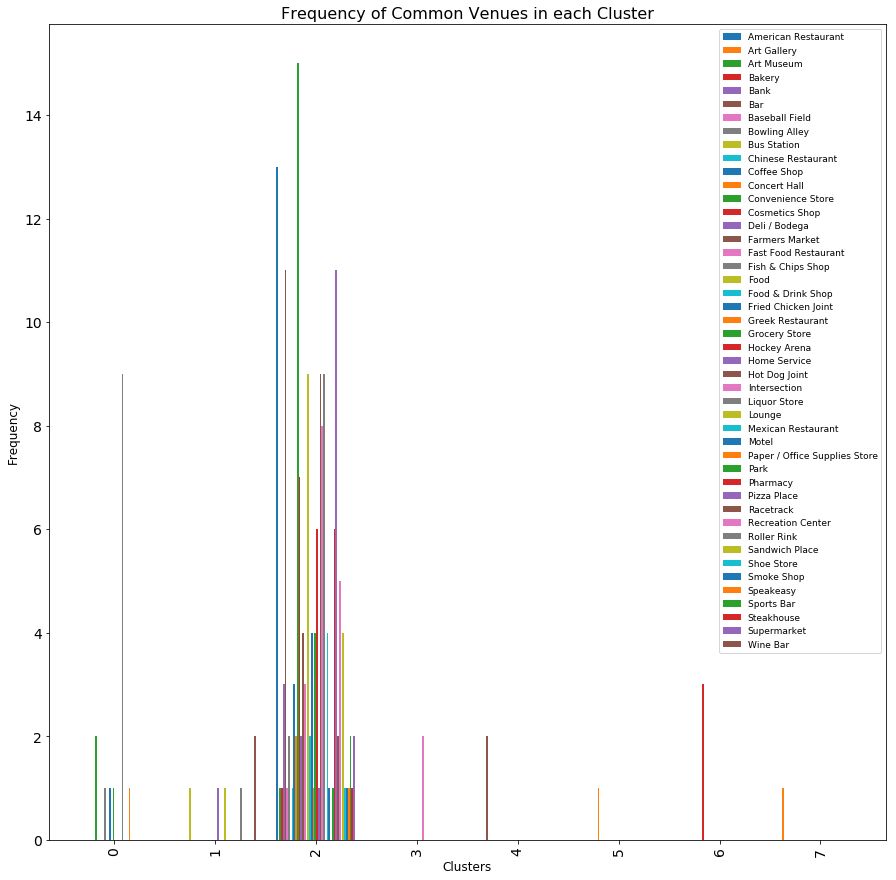

In [123]:
freq = df_1stcommon.plot(kind='bar',
                figsize=(15,15),
                width=0.8,
                fontsize=14)
freq.set_title("Frequency of Common Venues in each Cluster", fontsize=16)
freq.set_xlabel('Clusters', fontsize=12)
freq.set_ylabel('Frequency', fontsize=12)
freq.legend(loc='upper right', fontsize=9)

In [124]:
df_1stcommon.stack()

K-means Cluster Labels  1st Most Common Venue        
0                       Convenience Store                 2.0
                        Fish & Chips Shop                 1.0
                        Fried Chicken Joint               1.0
                        Grocery Store                     1.0
                        Liquor Store                      9.0
                        Paper / Office Supplies Store     1.0
1                       Bus Station                       1.0
                        Home Service                      1.0
                        Lounge                            1.0
                        Roller Rink                       1.0
                        Wine Bar                          2.0
2                       American Restaurant              13.0
                        Art Museum                        1.0
                        Bakery                            1.0
                        Bank                              3.0
                

It appears that each of the clusters are characterized by the following:

Cluster 0: liquor stores

Cluster 1: wine bar

Cluster 2: American restaurants, bars, convenience stores, pizza place, and food in general

Cluster 3: Intersection

Cluster 4: Bar

Cluster 5: Concert Hall/Cultural areas

Cluster 6: Cosemtics 

Cluster 7: Art Gallery

This can help greatly with public safety efforts.

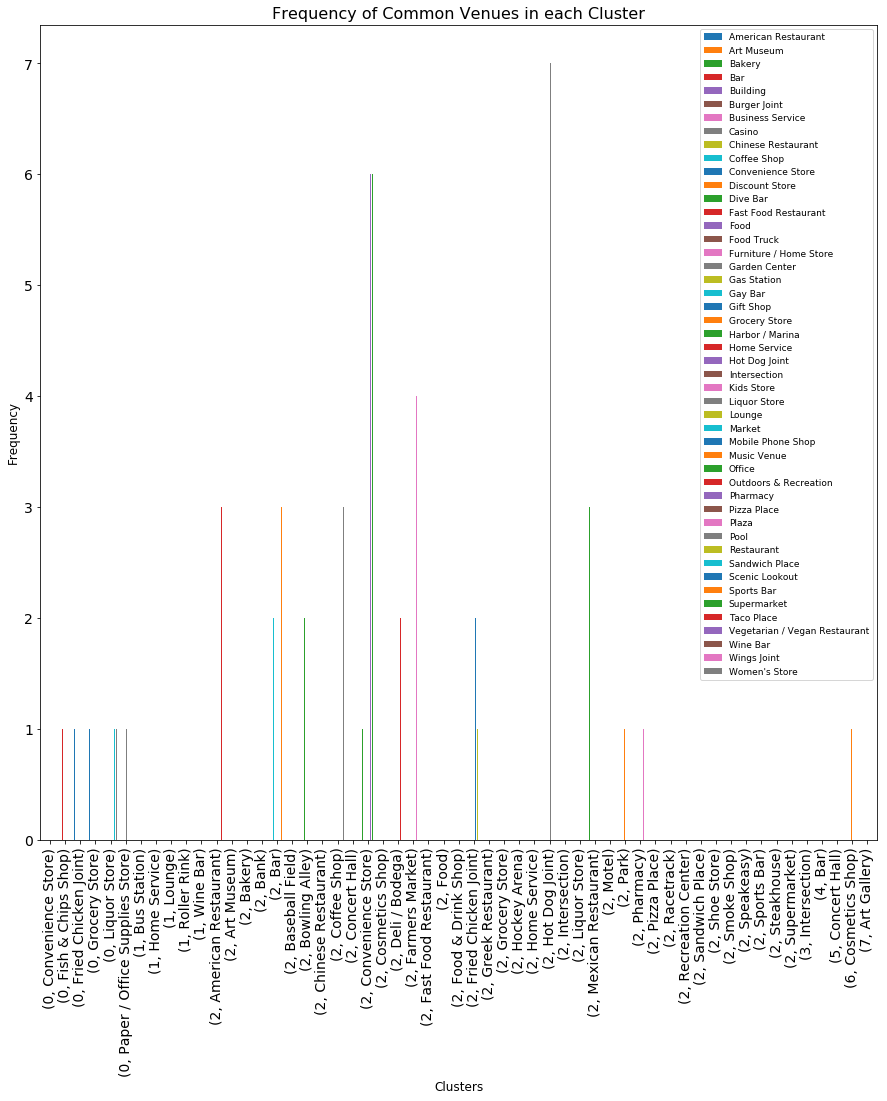

In [125]:
df_2ndcommon = detroit_merged.groupby(by=['K-means Cluster Labels','1st Most Common Venue', '2nd Most Common Venue']).size().unstack()
freq2 = df_2ndcommon.plot(kind='bar',
                figsize=(15,15),
                width=0.8,
                fontsize=14)
freq2.set_title("Frequency of Common Venues in each Cluster", fontsize=16)
freq2.set_xlabel('Clusters', fontsize=12)
freq2.set_ylabel('Frequency', fontsize=12)
freq2.legend(loc='upper right', fontsize=9)

In [126]:
df_2ndcommon.stack()

K-means Cluster Labels  1st Most Common Venue          2nd Most Common Venue        
0                       Convenience Store              Liquor Store                     2.0
                        Fish & Chips Shop              Fast Food Restaurant             1.0
                        Fried Chicken Joint            American Restaurant              1.0
                        Grocery Store                  American Restaurant              1.0
                        Liquor Store                   Convenience Store                1.0
                                                       Gas Station                      1.0
                                                       Intersection                     3.0
                                                       Restaurant                       2.0
                                                       Sandwich Place                   1.0
                                                       Women's Store                   